In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
import os
import folium
import pyproj
import json
import glob
from xml.dom import minidom
from matplotlib import pyplot as plt
from shapely.geometry.polygon import LinearRing
from shapely.geometry import Point
from shapely.geometry import box
from pyproj import Proj, transform
from pyproj import Transformer
import contextily as ctx

In [4]:
# Set the parent directory
parentDirectory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# Load the mode
os.chdir(parentDirectory)
# Load the pretrained model

with open('data/raw/sample_data/Locaties_vraag_aanbod.json') as f:
    data = json.load(f)

In [5]:
vraag = []
aanbod = []

# Check if aanbod (POINT) or vraag
for i in range(len(data['features'])):
    if data['features'][i]['geometry']['type'] == 'Point':
        aanbod.append(data['features'][i]['properties']['filename'])
    else:
        vraag.append(data['features'][i]['properties']['filename'])
        

# Create location list
VraagString = 'data/raw/sample_data/vraag/'
AanbodString = 'data/raw/sample_data/aanbod/'

VraagGML = [VraagString + i + '.gml' for i in vraag]
AanbodGML = [AanbodString + i + '.gml' for i in aanbod]

In [6]:
# list the pickles
pickles = glob.glob('data/processed/*.pkl')
gdfDict = {}

# Open all the pickles
for pickle in pickles:
    # Read df
    df = pd.read_pickle(parentDirectory + '/' + pickle)
    # Convert to gdf
    gdfDict[pickle[15:-4]] = gpd.GeoDataFrame(df, geometry=df['geometry'])

In [7]:
# Join based on location
gpdVraagAanbod = gpd.sjoin(gdfDict[vraag[0]], gdfDict[aanbod[0]], 
                           how="inner", 
                           op='within',
                           lsuffix='vraag',
                           rsuffix='aanbod')



In [8]:
gpdVraagAanbod['KanHet?'] = (gpdVraagAanbod['NH3_aanbod'] * 0.7) - (gpdVraagAanbod['NH3_vraag'] - 0.005)
gpdVraagAanbod['KanHet?'][gpdVraagAanbod['KanHet?'] < 0] = None

gdfVraagAanbodThresh = gpdVraagAanbod[gpdVraagAanbod['KanHet?'] < 0.0001]

bounds = gdfVraagAanbodThresh.total_bounds
bbox_sh = box(*bounds)
bbox_buffered = bbox_sh.buffer(5000)
gpd_bbox = gpd.GeoDataFrame(gpd.GeoSeries(bbox_buffered), columns=['geometry'])
gpd_bbox.crs = "EPSG:28992"

test = gpd.overlay(gpdVraagAanbod, gpd_bbox, how='intersection')

<ipython-input-8-8b43ebaa9f5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpdVraagAanbod['KanHet?'][gpdVraagAanbod['KanHet?'] < 0] = None


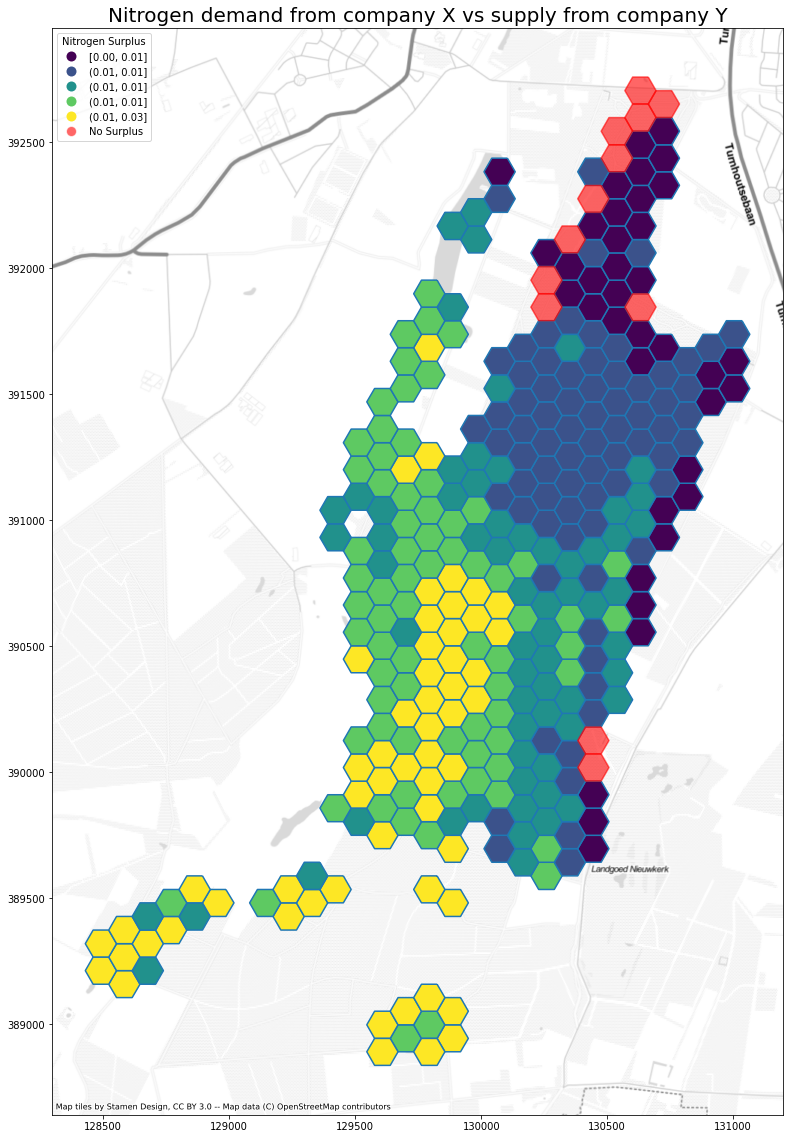

In [17]:
ax1 = test.plot(column='KanHet?',
                   figsize=(20, 20),
                   legend=True,
                   scheme='jenks_caspall',
                   facecolors= 'white',
                   alpha=1,
                   #edgecolor = (0,0,0,.5),
                   missing_kwds={
                        "color": "red",
                        "edgecolor": "white",
                        "facecolors": "red",
                        "label": "No Surplus",
                        "alpha": .6,
                        },
                   legend_kwds={'loc': 'upper left',
                                'title': 'Nitrogen Surplus'})

ax1.set_title("Nitrogen demand from company X vs supply from company Y", fontsize=20)

ax2 = ctx.add_basemap(ax1, 
                        source=ctx.providers.Stamen.TonerLite,
                        crs='EPSG:28992')


plt.savefig('Nitro.jpg')